Copyright 2021 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

#  Principal flow (PF) estimation for a quadratic case

Information about the principal flow can be found here: https://arxiv.org/abs/2302.01952

This colab implements the PF, as well as an example where the PF follows gradient descent exactly.

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import functools
import seaborn as sns

In [ ]:
gd_learning_rate = 1.05
num_gd_iterations = 5


In [ ]:

theta = np.array([-0.35, -0.2])

In [ ]:
l_max = 1.
l_min = 0.01
A = np.array([[l_max, 0.0], [0.0, l_min]])


In [ ]:
A.shape

(2, 2)

In [ ]:
def compute_hessian(f):
  # Note: the order is important, we use this order for efficiency.
  return jax.jacfwd(jax.jacrev(f, holomorphic=True), holomorphic=True)



In [ ]:
def loss(x):
  first_vec = jnp.dot(A, x)
  return jnp.sum(x * first_vec, axis=-1)

hessian_fn = compute_hessian(loss)
grad_fn = jax.jit(jax.grad(loss, holomorphic=True))

In [ ]:
loss(theta)

Array(0.12289999, dtype=float32)

In [ ]:
grad_fn(jnp.complex64(theta))

Array([-0.7  +0.j, -0.004+0.j], dtype=complex64)

In [ ]:
@functools.partial(jax.jit, static_argnums=(1))
def principal_series_modified_vector_field(params, include_higher_order=False):
    # hessian_eigenvals, hessian_eigenvecs = jnp.linalg.eigh(hessian_fn(params), symmetrize_input=True)
    # h = manual_hessian(params)
    h = hessian_fn(params)
    # print(h)
    hessian_eigenvals, hessian_eigenvecs = jnp.linalg.eig(h)

    dot_prods = jnp.einsum('ij,i', hessian_eigenvecs, grad_fn(params))
    # 1- h_lr will be real since the hessian is hermitian.
    # jax returns floats for the eigenvalues, so turn it into a complex nr.
    # we rely on jax to know that if the value is complex, it computes the
    # log correctly.
    h_lr = gd_learning_rate * hessian_eigenvals

    r = jnp.log(jnp.complex_(1 - h_lr)) / h_lr
    r = jnp.where(h_lr == 1., jnp.complex_(-100 * jnp.ones_like(r)), r)

    grads = - jnp.einsum('i,ji', dot_prods * r, hessian_eigenvecs)

    if include_higher_order:
      return grads + gd_learning_rate**2/12 * g_h_g_grad(params)

    return grads

In [ ]:
# @jax.jit
def g_h_g_with_stop(params):
  g = grad_fn(params)
  h = hessian_fn(params)
  return jnp.dot(jnp.dot(jax.lax.stop_gradient(g), h), jax.lax.stop_gradient(g))

g_h_g_grad = jax.grad(g_h_g_with_stop, holomorphic=True)

In [ ]:
@jax.jit
def third_order_modified_vector_field(params):
    grads = grad_fn(params)
    h = hessian_fn(params)

    return grads + gd_learning_rate/2 * jnp.dot(h, grads) + gd_learning_rate**2 * (1/3 * jnp.dot(h, jnp.dot(h, grads)) + 1./12 * g_h_g_grad(params))

In [ ]:
@jax.jit
def igr_vector_field(params):
    grads = grad_fn(params)
    h = hessian_fn(params)

    return grads + gd_learning_rate/2 * jnp.dot(h, grads)

In [ ]:

NUM_X = 20
NUM_Y = 10
xs = np.linspace(-0.4, 0.4, NUM_X)
ys = np.linspace(-0.3, 0.3, NUM_Y)

res = np.zeros((NUM_Y, NUM_X))
for i, y_val in enumerate(ys):
  for j, x_val in enumerate(xs):
    res[i, j] = loss(np.array([x_val, y_val]))


In [ ]:
res.shape

(10, 20)

<ipython-input-48-4e5672d92aa2>:2: UserWarning:

The following kwargs were not used by contour: 'linestyle'



Text(0.5, 1.0, 'Contours')

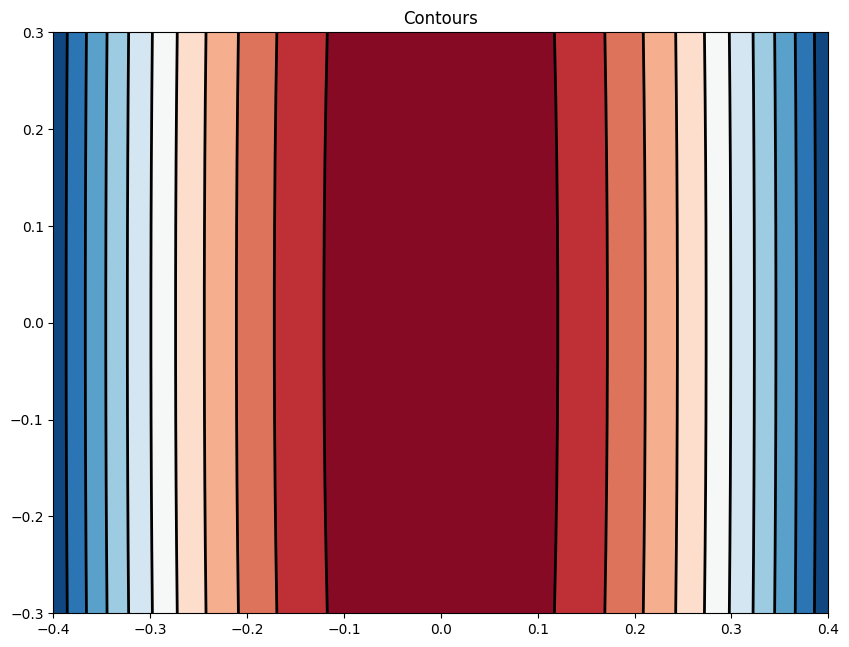

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.contour(xs, ys, res, 10, linewidths=2, colors='k', linestyle='solid')
ax.set_aspect('equal')
CS = ax.contourf(xs, ys, res, 10, cmap=plt.cm.RdBu)
plt.title('Contours')

In [ ]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'colab' # or 'notebook' or 'colab'

data = [
    go.Surface(
        x=xs,
        y=ys,
        z=res,
        surfacecolor=res,
    )
]
layout = go.Layout(
    title='Loss landscape',
    autosize=False,
    width=800,
    height=600,
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )
)
fig = go.Figure(data=data)
py.iplot(fig, filename='loss_landscape')


# Different flows

## Gradient descent

In [ ]:
gd_params_in_time = []
params = np.complex64(theta)
gd_params_in_time.append(params)

for i in range(num_gd_iterations):
  grads = grad_fn(params)
  params = params - gd_learning_rate * grads
  gd_params_in_time.append(params)

<ipython-input-51-531f93e0a35d>:2: UserWarning:

The following kwargs were not used by contour: 'linestyle'



Text(0, 0.5, 'y')

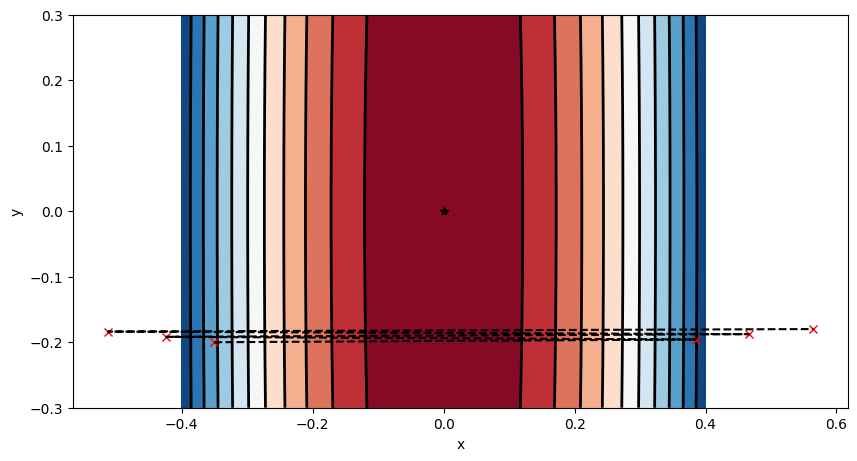

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.contour(xs, ys,res, 10, linewidths=2, colors='k', linestyle='solid')
ax.set_aspect('equal')
S = ax.contourf(xs, ys, res, 10, cmap=plt.cm.RdBu)

T = len(gd_params_in_time)

ax.plot([p[0] for p in gd_params_in_time], [p[1] for p in gd_params_in_time], 'x', c='r')
ax.plot([p[0] for p in gd_params_in_time], [p[1] for p in gd_params_in_time], '--', c='k')


plt.plot(0, 0, '*', c='k', label='global min', lw=10)


ax.set_xlabel('x')
ax.set_ylabel('y')


## Gradient flow

In [ ]:
gf_learning_rate = 0.00005
num_iterations = int(np.rint(gd_learning_rate/gf_learning_rate)) * num_gd_iterations

gf_params_in_time = []
params = np.complex64(theta)

for i in range(num_iterations):
  grads = grad_fn(params)
  params = params - gf_learning_rate * grads
  gf_params_in_time.append(params)

## Second order (IGR)

In [ ]:
gf_learning_rate = 0.00005
num_iterations = int(np.rint(gd_learning_rate/gf_learning_rate)) * num_gd_iterations
num_iterations = int(np.rint(gd_learning_rate/gf_learning_rate)) * 100
igr_params_in_time = []
params = np.complex64(theta)

for i in range(num_iterations):
  grads = igr_vector_field(params)
  params = params - gf_learning_rate * grads
  igr_params_in_time.append(params)

<ipython-input-54-1c95f7b9b8d0>:2: UserWarning:

The following kwargs were not used by contour: 'linestyle'



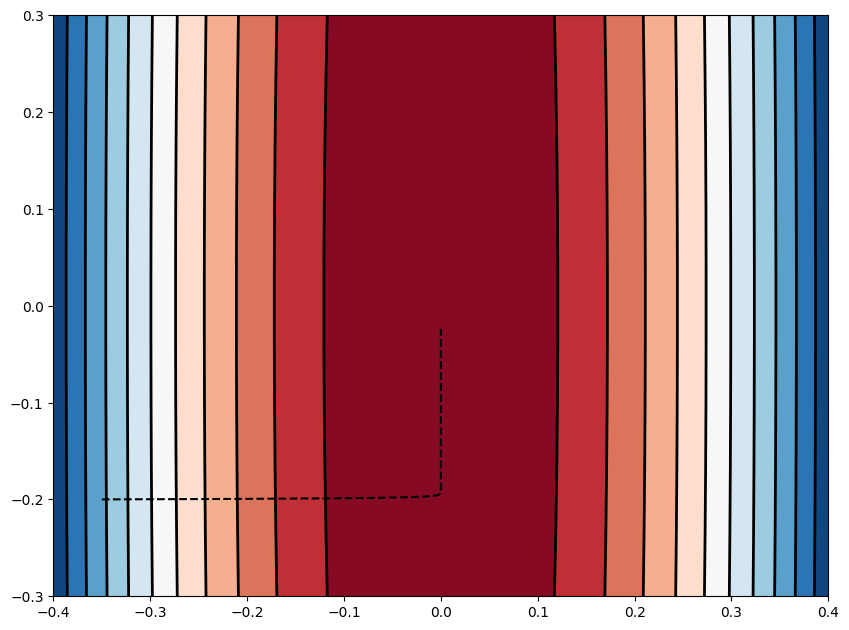

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.contour(xs, ys,res, 10, linewidths=2, colors='k', linestyle='solid')
ax.set_aspect('equal')
S = ax.contourf(xs, ys, res, 10, cmap=plt.cm.RdBu)

EVERY = 100
ax.plot([p[0] for p in igr_params_in_time[::100]], [p[1] for p in igr_params_in_time[::100]], '--', c='k')

## Principal ODE

In [ ]:
principal_learning_rate = 1e-5
num_iterations = int(np.rint(gd_learning_rate/principal_learning_rate)) * num_gd_iterations
principal_params_in_time = []

params = np.complex64(theta)
for i in range(num_iterations):
  grads = principal_series_modified_vector_field(params)
  params = params - principal_learning_rate * grads
  principal_params_in_time.append(params)

In [ ]:
len(principal_params_in_time)

525000

In [ ]:
principal_params_in_time[-1]

Array([ 0.5638127 -7.7996865e-06j, -0.17912096+0.0000000e+00j], dtype=complex64)

<ipython-input-58-0d042257776f>:2: UserWarning:

The following kwargs were not used by contour: 'linestyle'



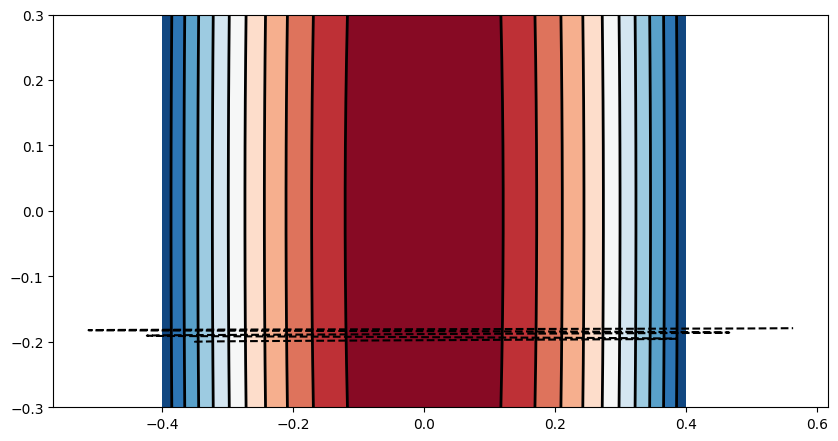

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.contour(xs, ys,res, 10, linewidths=2, colors='k', linestyle='solid')
ax.set_aspect('equal')
S = ax.contourf(xs, ys, res, 10, cmap=plt.cm.RdBu)

EVERY = 100
ax.plot([p[0] for p in principal_params_in_time[::100]], [p[1] for p in principal_params_in_time[::100]], '--', c='k')

## Plot all

In [ ]:

NUM_X = 20
NUM_Y = 10
xs = np.linspace(-0.6, 0.6, NUM_X)
ys = np.linspace(-0.45, 0.45, NUM_Y)

# xv, yv = np.meshgrid(xs, ys)

res = np.zeros((NUM_Y, NUM_X))
for i, y_val in enumerate(ys):
  for j, x_val in enumerate(xs):
    res[i, j] = loss(np.array([x_val, y_val]))

<ipython-input-60-1de3d119cce2>:2: UserWarning:

The following kwargs were not used by contour: 'linestyle'



([], [])

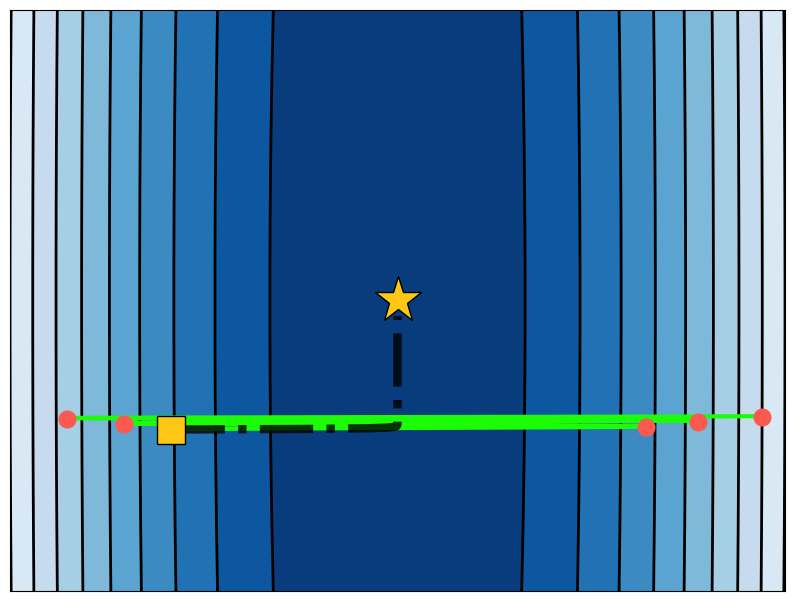

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.contour(xs, ys,res, 10, linewidths=2, colors='k', linestyle='solid')
ax.set_aspect('equal')

cmap = sns.color_palette("Blues_r", as_cmap=True)


S = ax.contourf(xs, ys, res, 10, cmap=cmap)


EVERY = 5000
plt.plot([p[0] for p in principal_params_in_time[::EVERY]], [p[1] for p in principal_params_in_time[::EVERY]],  c='xkcd:highlighter green', label='PF', lw=3)


plt.plot([p[0] for p in gd_params_in_time[1:]], [p[1] for p in gd_params_in_time[1:]], 'o', c='xkcd:coral', label='gradient descent', markersize=12)


plt.plot([p[0] for p in igr_params_in_time[::EVERY]], [p[1] for p in igr_params_in_time[::EVERY]],  c='k', ls='-.', label='IGR flow', lw=6, alpha=0.8)

plt.plot(0, 0, '*', c='xkcd:golden yellow', label='global min', markersize=35, markeredgecolor='k')
plt.plot(theta[0], theta[1], 's', c='xkcd:golden yellow', label='init point', markersize=20, markeredgecolor='k')

plt.xticks([], [])
plt.yticks([], [])



<ipython-input-61-cf5291b6fe73>:2: UserWarning:

The following kwargs were not used by contour: 'linestyle'



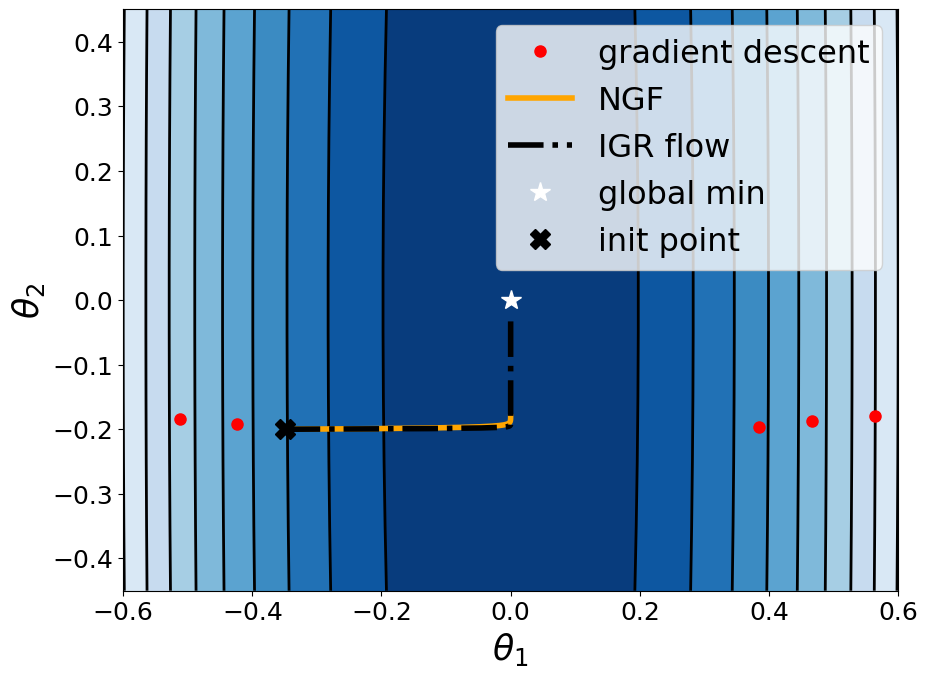

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.contour(xs, ys,res, 10, linewidths=2, colors='k', linestyle='solid')
ax.set_aspect('equal')

cmap = sns.color_palette("Blues_r", as_cmap=True)


S = ax.contourf(xs, ys, res, 10, cmap=cmap)


plt.plot([p[0] for p in gd_params_in_time[1:]], [p[1] for p in gd_params_in_time[1:]], 'o', c='r', label='gradient descent', markersize=8)


EVERY = 5000

plt.plot([p[0] for p in gf_params_in_time[::EVERY]], [p[1] for p in gf_params_in_time[::EVERY]],  c='orange', label='NGF', lw=4)

plt.plot([p[0] for p in igr_params_in_time[::EVERY]], [p[1] for p in igr_params_in_time[::EVERY]],  c='k', ls='-.', label='IGR flow', lw=4)

plt.xlabel(r'$\theta_1$', fontsize=25)
plt.ylabel(r'$\theta_2$', fontsize=25)


plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=18)

plt.plot(0, 0, '*', c='w', label='global min', markersize=15)
plt.plot(theta[0], theta[1], 'X', c='k', label='init point', markersize=15)



plt.legend(fontsize=23)